https://vene.ro/figurative-comparisons/#dataset

http://www.ep.liu.se/ecp/126/004/ecp16126004.pdf

https://www.aclweb.org/anthology/P13-3013

http://www.cs.toronto.edu/~frank/csc401/readings/ReynoldsRose.pdf

https://ansible.uk/misc/striking.html

in similes.txt, all phrases starting with 'Like' and 'As' were removed

Any old English, like "a flutter'd bird" were translated to modern spellings.

https://github.com/allenai/bilm-tf

http://www.english.su.se/polopoly_fs/1.100637.1347450592!/menu/standard/file/SMF_2012_Patrick_Hanks_plenary.pdf

https://www.academicscope.com/literature-review-on-automatic-simile-and-metaphor-recognizers/

McLachlan, G. J., & Rathnayake, S. (2014). On the number of components in a Gaussian mixture model. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 4(5), 341-355.

http://aclweb.org/anthology/W18-09

Computational considerations of comparisons and similes
https://www.aclweb.org/anthology/P13-3013

A Computational System of Metaphor Generation with Evaluation Mechanism
https://rd.springer.com/content/pdf/10.1007%2F978-3-642-15822-3_18.pdf

Towards the Automatic Mining of Similes in Literary Texts
http://www.ep.liu.se/ecp/126/004/ecp16126004.pdf

Literature Review on Automatic Simile and Metaphor Recognizers
https://www.academicscope.com/literature-review-on-automatic-simile-and-metaphor-recognizers/

https://github.com/alexWhitworth/emclustr/blob/master/R/clust_mvn_miss.R

In [1]:
import pandas as pd
import numpy as np

from itertools import permutations
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist

from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.keyedvectors import KeyedVectors
import spacy

nlp = spacy.load('en_core_web_sm')

In [2]:
# from allennlp.commands.elmo import ElmoEmbedder
# elmo = ElmoEmbedder()

In [2]:
model = KeyedVectors.load_word2vec_format('/Volumes/microSD/COGS118b/google-news.bin', binary=True)

# Simile data

Components are manually extracted

In [3]:
component_tags = ['topic', 'event', 'ground', 'vehicle']

In [4]:
sentences = pd.read_json('similes.json', orient='records')

%time sentences['nlp'] = sentences['original'].apply(lambda text: nlp(text))

len(sentences)

CPU times: user 5.71 s, sys: 197 ms, total: 5.91 s
Wall time: 3.11 s


345

In [5]:
def embed_tokens(tokens):
    
#     elmo_v = elmo.embed_sentence(tokens)[1]

    w2v_v = np.ones((len(tokens), 300)) * np.nan
    for i, tk in enumerate(tokens):
        try:
            w2v_v[i, :] = model[tk]
        except:
            if tk not in OOV:
                OOV.append(tk)
    
    return w2v_v #np.hstack([elmo_v, w2v_v])

In [6]:
OOV = []

topic_vectors =   np.zeros((len(sentences), 300))
event_vectors =   np.zeros((len(sentences), 300))
ground_vectors =  np.zeros((len(sentences), 300))
vehicle_vectors = np.zeros((len(sentences), 300))

for ix, s in sentences.iterrows():
    
    tokens = np.array([tk.text for tk in s['nlp']])
    embedding = embed_tokens(tokens)
        
    for tag, vec in zip(component_tags, [topic_vectors, event_vectors, ground_vectors, vehicle_vectors]):
        if s[tag]:
            emb = embedding[s[tag], :]
            
            if np.isnan(emb).all():
                print(ix, tag)
                mn = np.zeros((300, ))
            else:
                mn = np.nanmean(emb, axis=0)

            vec[ix] = mn

220 event
280 ground
332 ground


In [7]:
print(OOV)

['a', 'and', 'of', 'to', 'Pillowed', 'overwearied', ',', 'lampless', '-', "'s", 'graved', "'", 'empurpled', 'hadst', 'dovelike', 'Shrivel', 'rosewhite', 'Beauteous', 'unfallen', 'bleared', 'Shapeless', 'aigrette']


# Similarity with Latent Component

If we remove a component, the overall syntatical expression remains with a predictability that hopefully can be leveraged with a Gaussian Mixture Model (or some other latent variable maximization algorithm). 

In [113]:
inp = {'original': 'His love burned as passionately as', 'topic': [0,1], 'ground': [4], 'event': [2], 'vehicle': None}

tokens = np.array([tk.text for tk in nlp(inp['original'])])

example_topic_vector =   np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
example_event_vector =   np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
example_ground_vector =  np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
example_vehicle_vector = np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))

embedding = embed_tokens(tokens)

if inp['topic']:
    example_topic_vector = embedding[inp['topic']].mean(axis=0)
if inp['event']:
    example_event_vector = embedding[inp['event']].mean(axis=0)
if inp['ground']:
    example_ground_vector = embedding[inp['ground']].mean(axis=0)
if inp['vehicle']:
    example_vehicle_vector = embedding[inp['vehicle']].mean(axis=0)


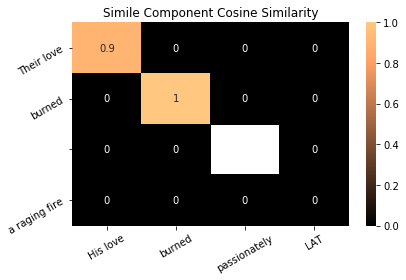

In [114]:
yax_labs = ['', '', '', '']
xax_labs = ['', '', '', '']
ds = np.zeros((4,4))

comp = 14

norm = [topic_vectors[comp, :], event_vectors[comp, :], ground_vectors[comp, :], vehicle_vectors[comp, :]]
example = [example_topic_vector, example_event_vector, example_ground_vector, example_vehicle_vector]
labels = ['topic', 'event', 'ground', 'vehicle']

for i in range(4):
    e = sentences.loc[comp, [labels[i], 'original']].values
    phrase1 = np.array([tk.text for tk in nlp(e[1])])[e[0]]
    yax_labs[i] = ' '.join(phrase1)
    if inp[labels[i]]:
        d = 1 - pdist(np.vstack([norm[i], example[i]]), 'cosine')
    
        ds[i, i] = d
        
        e = sentences.loc[comp, [labels[i], 'original']].values
        
        phrase2 = np.array([tk.text for tk in nlp(inp['original'])])[inp[labels[i]]]
        xax_labs[i] = ' '.join(phrase2)
    elif inp[labels[i]] is None:
        xax_labs[i] = 'LAT'

g = sns.heatmap(ds, vmin=0, vmax=1, annot=True, cmap='copper')
g.set_xticklabels(xax_labs, rotation=30);
g.set_yticklabels(yax_labs, rotation=30);
plt.title('Simile Component Cosine Similarity')
plt.tight_layout()
plt.savefig('component_cos_similarity.png', dpi=300)

# Dimension Reduction

In [10]:
def get_component(simile_ix, comp):
    comp = sentences.loc[simile_ix, comp]
    return ' '.join([tk.text for i, tk in enumerate(sentences.loc[simile_ix, 'nlp']) if i in comp])

# GMM

Check the mean/skew/kurtosis visually of the embeddings

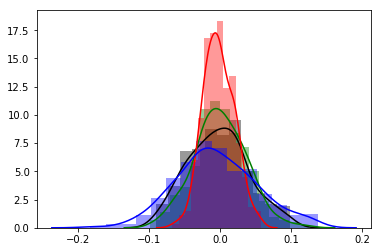

In [11]:
sns.distplot(topic_vectors.mean(axis=0), color='k')
sns.distplot(event_vectors.mean(axis=0), color='g')
sns.distplot(ground_vectors.mean(axis=0), color='r')
sns.distplot(vehicle_vectors.mean(axis=0), color='b')

In [12]:
ns = np.linspace(int(len(sentences)*0.04), int(len(sentences)*0.96), 24).astype(int)

\# of components relies on the complexity of the input vectors

In [13]:
import random
vecs_shuffled_all = np.array([
    random.sample(topic_vectors.tolist(), len(topic_vectors)),
    random.sample(event_vectors.tolist(), len(event_vectors)), 
    random.sample(ground_vectors.tolist(), len(ground_vectors)), 
    random.sample(vehicle_vectors.tolist(), len(vehicle_vectors))])

# Autoencoder

In [52]:
from keras.layers import Input, Dense
from keras.models import Model

/Users/alex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [175]:
def create_encoder(data, encoding_dim):

    input_vec = Input(shape=(300,))
    encoded = Dense(128, activation='sigmoid')(input_vec)
    encoded = Dense(encoding_dim, activation='sigmoid')(encoded)
    
    decoded = Dense(128, activation='sigmoid')(encoded)
    decoded = Dense(300, activation='sigmoid')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_vec, decoded)
    encoder = Model(input_vec, encoded)
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    st = np.array(random.sample(data, len(data)))

    X_train = st[:int(len(data) * 0.6), :]
    X_test = st[int(len(data) * 0.6):, :]
    
    h = autoencoder.fit(X_train, X_train,
                    epochs=120,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(X_test, X_test), verbose=0)
    
    histories.append(h.history['loss'])
    
    print(f'Fit {encoding_dim}')
    
    return encoder

In [176]:
dims = [8, 16, 32, 64]


histories = []

encoders = [[
    create_encoder(topic_vectors.tolist(), dim),
    create_encoder(event_vectors.tolist(), dim),
    create_encoder(ground_vectors.tolist(), dim),
    create_encoder(vehicle_vectors.tolist(), dim)
] for dim in dims]

Fit 8
Fit 8
Fit 8
Fit 8
Fit 16
Fit 16
Fit 16
Fit 16
Fit 32
Fit 32
Fit 32
Fit 32
Fit 64
Fit 64
Fit 64
Fit 64


In [177]:
vecs_array = np.array([topic_vectors, event_vectors, ground_vectors, vehicle_vectors])

scores = np.zeros((len(dims), len(ns)))
    
for i, dim in enumerate(dims):

    redu_topic_vectors = encoders[i][0].predict(vecs_array[0])
    redu_event_vectors = encoders[i][1].predict(vecs_array[1])
    redu_ground_vectors = encoders[i][2].predict(vecs_array[2])
    redu_vehicle_vectors = encoders[i][3].predict(vecs_array[3])

    redu_shuf_topic_vectors = encoders[i][0].predict(vecs_shuffled_all[0])
    redu_shuf_event_vectors = encoders[i][1].predict(vecs_shuffled_all[1])
    redu_shuf_ground_vectors = encoders[i][2].predict(vecs_shuffled_all[2])
    redu_shuf_vehicle_vectors = encoders[i][3].predict(vecs_shuffled_all[3])

    redu_all = np.hstack([redu_topic_vectors, redu_event_vectors, redu_ground_vectors, redu_vehicle_vectors])
    redu_shuf_all = np.hstack([redu_shuf_topic_vectors, redu_shuf_event_vectors, redu_shuf_ground_vectors, redu_shuf_vehicle_vectors])

    # calculate some metric for GMM of n components
    for j, n_comp in enumerate(ns):
        gm = GaussianMixture(n_components=n_comp, covariance_type='diag', n_init=4, init_params='random', tol=1e-3,
                            warm_start=True)

        gmf = gm.fit(redu_all)

        scores[i, j] = gmf.aic(redu_all) - gmf.aic(redu_shuf_all)

    print(f'Search over {dim} finished')

Search over 8 finished
Search over 16 finished
Search over 32 finished
Search over 64 finished


In [178]:
top_dim, top_comp = np.unravel_index(np.argmin(scores), scores.shape)

ns[top_comp], dims[top_dim], scores[top_dim, top_comp]

(331, 64, -455034.52453004726)

64 -455,034.52453004726


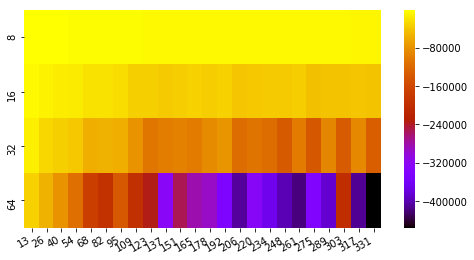

In [179]:
plt.subplots(figsize=(8,4))
g = sns.heatmap(scores[:, :], cmap='gnuplot', vmin=np.min(scores), vmax=np.max(scores))
g.set_yticklabels(dims)
g.set_xticklabels(ns, rotation=30, ha='right');

y, x = np.unravel_index(np.argmin(scores[:, :]), scores[:, :].shape)
print(f'{dims[y]} {scores[y, x]:,}')

# plt.text(x+0.5, y+0.3, f'{ns[x]} - {decomp_levels[y]}', ha='center', color='w');
# plt.scatter(x+0.5, y+0.5, s=50, c='w')

# Kernel PCA

In [82]:
def sum_squares(x):
    
    return np.sum(np.power(x - np.mean(x), 2))
    

In [103]:
vecs_array = np.array([topic_vectors, event_vectors, ground_vectors, vehicle_vectors])

dims = [10, 15, 20, 25, 50, 75]
scores = np.zeros((len(dims), len(ns)))
metric = np.zeros((len(dims), len(ns)))
    
for i, dim in enumerate(dims):
    
    decomp_topic = KernelPCA(n_components=dim, kernel='rbf', gamma=0.3)
    decomp_event = KernelPCA(n_components=dim, kernel='rbf', gamma=0.3)
    decomp_ground = KernelPCA(n_components=dim, kernel='rbf', gamma=0.3)
    decomp_vehicle = KernelPCA(n_components=dim, kernel='rbf', gamma=0.3)

    redu_topic_vectors = decomp_topic.fit_transform(vecs_array[0])
    redu_event_vectors = decomp_event.fit_transform(vecs_array[1])
    redu_ground_vectors = decomp_ground.fit_transform(vecs_array[2])
    redu_vehicle_vectors = decomp_vehicle.fit_transform(vecs_array[3])

    redu_shuf_topic_vectors = decomp_topic.fit_transform(vecs_shuffled_all[0])
    redu_shuf_event_vectors = decomp_event.fit_transform(vecs_shuffled_all[1])
    redu_shuf_ground_vectors = decomp_ground.fit_transform(vecs_shuffled_all[2])
    redu_shuf_vehicle_vectors = decomp_vehicle.fit_transform(vecs_shuffled_all[3])

    redu_all = np.hstack([redu_topic_vectors, redu_event_vectors, redu_ground_vectors, redu_vehicle_vectors])
    redu_shuf_all = np.hstack([redu_shuf_topic_vectors, redu_shuf_event_vectors, redu_shuf_ground_vectors, redu_shuf_vehicle_vectors])

    # calculate some metric for GMM of n components
    for j, n_comp in enumerate(ns):
        gm = GaussianMixture(n_components=n_comp, covariance_type='diag', n_init=4, init_params='random', tol=1e-3,
                            warm_start=True)

        gmf = gm.fit(redu_all)

        scores[i, j] = gmf.aic(redu_all) - gmf.aic(redu_shuf_all)
        
        pred = gm.predict(redu_all)
        _, count = np.unique(pred, return_counts=True)
        metric[i, j] = entropy(count)
        

    print(f'Search over {dim} finished')

Search over 10 finished
Search over 15 finished
Search over 20 finished
Search over 25 finished
Search over 50 finished
Search over 75 finished


In [100]:
from scipy.stats import entropy

In [95]:
top_dim, top_comp = np.unravel_index(np.argmin(scores), scores.shape)

ns[top_comp], dims[top_dim], scores[top_dim, top_comp]

(234, 10, -56139896.078501575)

50 331 -45,082,071


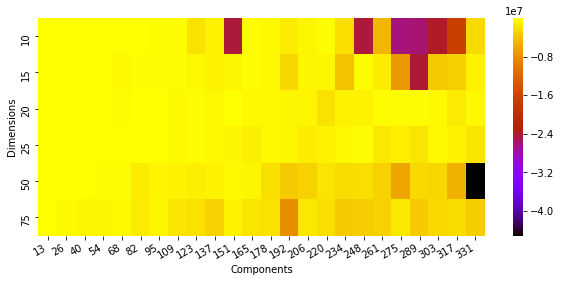

In [108]:
plt.subplots(figsize=(10,4))
cb = scores / metric
g = sns.heatmap(cb, cmap='gnuplot', vmin=np.min(cb), vmax=np.max(cb))
g.set_yticklabels(dims)
g.set_xticklabels(ns, rotation=30, ha='right')
plt.xlabel('Components')
plt.ylabel('Dimensions')

y, x = np.unravel_index(np.argmin(cb[:, :]), cb[:, :].shape)
print(f'{dims[y]} {ns[x]} {int(cb[y, x]):,}')

In [92]:
-6000000 / 3, -6000000 / 300, -60000 / 3, -60000 / 300

(-2000000.0, -20000.0, -20000.0, -200.0)

In [105]:
print(entropy(np.array([1,1,1,1,1,1,1,1,1,20,50]) / 79)) # bad, all in one component
print(entropy(np.array([1,1,50])/ 52)) # all in one comp
print(entropy(np.array([1,2,4,8,16,20,26,30,40,50]) / 197)) # more spread
print(entropy(np.array([30,30,28,30,30,34]) / 182)) # even

1.1350706911697162
0.1896831364389792
1.9443924138123927
1.7900414677289174


20 2


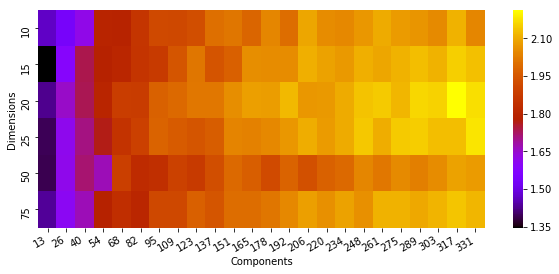

In [104]:
plt.subplots(figsize=(10,4))
metric = np.sqrt(metric)
g = sns.heatmap(metric[:, :], cmap='gnuplot', vmin=np.min(metric), vmax=np.max(metric))
g.set_yticklabels(dims)
g.set_xticklabels(ns, rotation=30, ha='right')
plt.xlabel('Components')
plt.ylabel('Dimensions')

y, x = np.unravel_index(np.argmax(metric[:, :]), metric[:, :].shape)
print(f'{dims[y]} {int(metric[y, x]):,}')

In [116]:
# redu_topic_vectors = encoders[0][0].predict(vecs_array[0])
# redu_event_vectors = encoders[0][1].predict(vecs_array[1])
# redu_ground_vectors = encoders[0][2].predict(vecs_array[2])
# redu_vehicle_vectors = encoders[0][3].predict(vecs_array[3])
# dims[top_dim]
decomp_topic = KernelPCA(n_components=20, kernel='rbf', gamma=0.3)
decomp_event = KernelPCA(n_components=20, kernel='rbf', gamma=0.3)
decomp_ground = KernelPCA(n_components=20, kernel='rbf', gamma=0.3)
decomp_vehicle = KernelPCA(n_components=20, kernel='rbf', gamma=0.3)

redu_topic_vectors = decomp_topic.fit_transform(vecs_array[0])
redu_event_vectors = decomp_event.fit_transform(vecs_array[1])
redu_ground_vectors = decomp_ground.fit_transform(vecs_array[2])
redu_vehicle_vectors = decomp_vehicle.fit_transform(vecs_array[3])

redu_array = np.array([redu_topic_vectors, redu_event_vectors, redu_ground_vectors, redu_vehicle_vectors])
redu_all = np.hstack(redu_array)

print(redu_all.shape)

n_comps = 317 #ns[top_comp]
gm = GaussianMixture(n_components=n_comps, covariance_type='diag', n_init=10, init_params='random', tol=1e-3)

%time gmf = gm.fit(redu_all)

gm

(345, 80)
CPU times: user 1.69 s, sys: 46.8 ms, total: 1.73 s
Wall time: 1.11 s


GaussianMixture(covariance_type='diag', init_params='random', max_iter=100,
        means_init=None, n_components=317, n_init=10, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

# Generative Model

In [117]:
rvs = [multivariate_normal(mean=gmf.means_[i, :], cov=gmf.covariances_[i, :]) for i in range(n_comps)]

In [150]:
def cycle_latent_data(input_dict, verbose=0):
    global component_ixs

    tv = np.random.normal(scale=0.3, size=(1,300))#np.zeros((1, 300))
    ev = np.random.normal(scale=0.3, size=(1,300))#np.zeros((1, 300))
    gv = np.random.normal(scale=0.3, size=(1,300))#np.zeros((1, 300))
    vv = np.random.normal(scale=0.3, size=(1,300))#np.zeros((1, 300))

    embedding = embed_tokens(input_dict['tokens'])
    
    latent = []

    if input_dict['topic']:
        tv = np.nanmean(embedding[input_dict['topic']], axis=0)
    else:
        latent.append('topic')

    if input_dict['event']:
        ev = np.nanmean(embedding[input_dict['event']], axis=0)
    else:
        latent.append('event')

    if input_dict['ground']:
        gv = np.nanmean(embedding[input_dict['ground']], axis=0)
    else:
        latent.append('ground')

    if input_dict['vehicle']:
        vv = np.nanmean(embedding[input_dict['vehicle']], axis=0)
    else:
        latent.append('vehicle')   
        
    out = []
        
    for mix in permutations(latent):
        # original input, reduced
#         combined = np.array([encoders[0][0].predict(np.atleast_2d(tv)), 
#                              encoders[0][1].predict(np.atleast_2d(ev)), 
#                              encoders[0][2].predict(np.atleast_2d(gv)), 
#                              encoders[0][3].predict(np.atleast_2d(vv))])
        
        combined = np.array([decomp_topic.transform(np.atleast_2d(tv)), 
                             decomp_event.transform(np.atleast_2d(ev)), 
                             decomp_ground.transform(np.atleast_2d(gv)), 
                             decomp_vehicle.transform(np.atleast_2d(vv))])
        
        mixout = []
        
        if verbose > 0:
            print(f'Testing: {mix}')
        
        for lat in mix:
            component_ixs = [0,1,2,3]
            ix = component_tags.index(lat)
            del component_ixs[ix]
            
            if verbose > 1:
                print(f'Search for most probable: {lat}')
            latent, vocab_ix, comp, post_prob = cycle_potential_vocab(lat, combined[component_ixs])
                        
            mixout.append([ix, vocab_ix, comp, post_prob])
            
            # update the latent component to the value that maximizes the current probability
            combined[ix] = redu_array[ix, vocab_ix]
            if verbose > 1:
                print(f'Fill latent with "{get_component(vocab_ix, latent).lower()}"')
            
        out.append(mixout)
        if verbose > 2:
            print(f'MLE: {np.array(mixout)[:, 3].sum():.3f}')
        if verbose > 0:
            print()
        
    return np.array(out)

def cycle_potential_vocab(latent_component, remaining_components):
    '''
    Given an unknown vector, but three known vectors, iterate over all vocabularly possibilities to
    maximize the likelihood.
    
    i.e. choose the best vocab for the missing data
    '''
    if latent_component is 'topic':
        posteriors = np.array([choose_best_mixture(np.atleast_2d(vec), 
                               remaining_components[0], 
                               remaining_components[1], 
                               remaining_components[2]) 
                               for vec in redu_topic_vectors])

    
    elif latent_component is 'event':
        posteriors = np.array([choose_best_mixture(remaining_components[0], 
                               np.atleast_2d(vec), 
                               remaining_components[1], 
                               remaining_components[2]) 
                               for vec in redu_event_vectors])
        
    elif latent_component is 'ground':
        posteriors = np.array([choose_best_mixture(remaining_components[0], 
                               remaining_components[1], 
                               np.atleast_2d(vec), 
                               remaining_components[2]) 
                               for vec in redu_ground_vectors])

    elif latent_component is 'vehicle':
        posteriors = np.array([choose_best_mixture(remaining_components[0], 
                               remaining_components[1], 
                               remaining_components[2], 
                               np.atleast_2d(vec)) 
                               for vec in redu_vehicle_vectors])

    m = np.argmax(posteriors[:, 1])
    return latent_component, m, posteriors[m, 0], posteriors[m, 1]
    
def choose_best_mixture(topic, event, ground, vehicle):
    '''
    Given four vector components, return the MLE of which Gaussian component the vectors should
    belong to.
    
    i.e. choose the best model for and probability of the given data
    '''
    redu_all = np.hstack([topic, event, ground, vehicle])
            
    posteriors = [rvs[gmm_comp].logpdf(redu_all) for gmm_comp in range(n_comps)]
                        
    return (np.argmax(posteriors), np.max(posteriors))

In [148]:
def piece_fit(fit):
    complete = {}
    component_ixs = [0,1,2,3]
    for comp_ix in component_ixs:
        tag = component_tags[comp_ix]

        if comp_ix in fit[:, 0].astype(int):
            w = np.where(fit[:, 0].astype(int) == comp_ix)[0]
            text = get_component(int(fit[w, 1]), tag)
            complete[tag] = text
        else:
            complete[tag] = " ".join(inp["tokens"][inp[tag]])

    return complete

def format_simile(components):
    
    t = components['topic']
    e = components['event']
    g = components['ground']
    v = components['vehicle']
    
    if g and t and e and v:
        return f'{t} {e} as {g} as {v}'.capitalize()
    elif not g and t and e and v:
        return f'{t} {e} like {v}'.capitalize()
    elif not t and g and not e and v:
        return f'{g} like {v}'.capitalize()
    elif not e and t and g and v:
        return f'{t} as {g} as {v}'.capitalize()
    elif not t and e and g and v:
        return f'{e} {g} as {v}'.capitalize()
    elif not t and not g and e and v:
        return f'{e} like {v}'.capitalize()
    else:
        return components

In [152]:
inp = {'original': 'is as smart as', 'topic': None, 'ground': [2], 'event': [0], 'vehicle': None}
inp['tokens'] = np.array([tk.text for tk in nlp(inp['original'])])

z = cycle_latent_data(inp, verbose=3)

best_fit = np.argmax(np.sum(z[:, :, 3], axis=1))

format_simile(piece_fit(z[best_fit]))

Testing: ('topic', 'vehicle')
Search for most probable: topic
Fill latent with "her humor"
Search for most probable: vehicle
Fill latent with "a lampless sea"
MLE: 188.668

Testing: ('vehicle', 'topic')
Search for most probable: vehicle
Fill latent with "a sea"
Search for most probable: topic
Fill latent with "her humor"
MLE: 212.065



'Her humor is as smart as a sea'

In [142]:
z[best_fit, :, :]

array([[  3.        ,  79.        , 234.        , 479.10533966]])

In [140]:
sentences.iloc[65:100]

,event,ground,original,topic,vehicle,nlp
65,[],[1],As black as coal,[],[3],"(As, black, as, coal)"
66,[],[1],As hot as hell,[],[3],"(As, hot, as, hell)"
67,[],[1],As cool as a cucumber,[],"[3, 4]","(As, cool, as, a, cucumber)"
68,[],[1],As tough as nails,[],[3],"(As, tough, as, nails)"
69,[],[1],As blind as a bat,[],"[3, 4]","(As, blind, as, a, bat)"
70,[],[1],As light as a feather,[],"[3, 4]","(As, light, as, a, feather)"
71,[],[1],As bright as a button,[],"[3, 4]","(As, bright, as, a, button)"
72,[],[1],As common as dirt,[],[3],"(As, common, as, dirt)"
73,[],[1],As bold as brass,[],[3],"(As, bold, as, brass)"
74,[],[1],As sweet as sugar,[],[3],"(As, sweet, as, sugar)"


In [120]:
p = gmf.predict(redu_all)

a, b = np.unique(p, return_counts=True)

print(b.std())
print(entropy(b))

cc = pd.DataFrame({'component': a, 'count': b}).sort_values(ascending=False, by='count')

cc.head(10)

2.5315539738032515
4.811307273655414


,component,count
7,15,27
179,307,14
157,266,13
16,27,7
136,230,7
131,219,6
132,221,6
66,103,6
122,199,6
127,207,5


In [143]:
cc.loc[cc['component'] == 234]

,component,count
138,234,1


In [136]:
sentences.loc[p == 128, 'original'].values

array(['As bright as a button', 'As bold as brass',
       'Impassive as a statue'], dtype=object)